# Final Exam (part 2) - Computational Physics 2

### Deadline: Friday 6 June 2025 (by 23h59)
### Credits: 10 points

### Please keep the structure provided below and submit an organised notebook with clear answers to each item.


## 2. FFT method for fluid dynamics: 1D Shock waves

We wish to study the emergence of 1D shock waves in fluids. To do this we will modify our one-way wave equation to account for non-linear convection, i.e. we will consider that the speed of an initial Gaussian density perturbation $\rho(x, 0) = 4\,e^{-x^2}$ propagating across a periodic 1D domain is not constant, but a function of the density itself, so that our PDE becomes:

$$\frac{\partial \rho}{\partial t} + \rho\frac{\partial \rho}{\partial x} =0$$


As we see from the above equation, portions of $\rho$ with larger amplitudes will convect more rapidly, giving rise to wave steepening (i.e. to a discontinuity, which we call a **shock wave**). Without a diffusive term, the shock would become infinitely steep. Therefore, we add a diffusive (parabolic) term to our PDE so that the shock maintains a finite width. Our PDE then becomes:

$$\frac{\partial \rho}{\partial t} + \rho\frac{\partial \rho}{\partial x} =\alpha\frac{\partial^2 \rho}{\partial x^2}$$

where $\alpha$ is a diffusion constant.

Implement the following tasks using **python classes**:

**(a)** Create an appropriate domain and a reasonable time vector for the problem, and make a plot of the initial density profile.

In [1]:
# Third party libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scienceplots
import os
import glob
from PIL import Image 
import multiprocessing as mp

# Define the style for plotting
plt.style.use(['science', 'notebook', 'no-latex']) 

In [2]:
class ShockWavesInitialProfile:
    """
    
    """
    def __init__(self, dx = 0.1, Lx = 10.0, dt = 0.01, time_tot = 5.0):
        """
        Initialize the ShockWaves class with parameters for simulation.
            Inputs:
                dx (float): Spatial step size.
                Lx (float): Length of the domain.
                dt (float): Time step size.
                time_tot (float): Total simulation time.
        """
        self.dx = dx
        self.Lx = Lx
        self.dt = dt
        self.time_tot = time_tot
    
        # Time domain
        self.t = np.arange(0, time_tot + dt, dt)

        # Spacial domain
        self.x = np.arange(-Lx/2, Lx/2, dx)

        # Initialize the initial profile
        self.gaussian_init()

    def gaussian_init(self):
        """
        Funtion to initialize a Gaussian function in the spatial domain.
            Input:
                x (array): Spatial points.
            Output:
                rho_0 (array): Save the initial Gaussian distribution.
        """
        rho_0 = 4*np.exp(-self.x**2)

        # Save the intial profile
        self.rho_0 = rho_0
    
    def plot_initial_profile(self):
        """
        Plot the initial profile of the Gaussian function.
            Output:
                A plot of the initial Gaussian distribution.
        """

        plt.figure(figsize=(10, 5))

        plt.plot(self.x, self.rho_0, label=r"$\rho(x, 0)$", color="blue")
        plt.title("Initial Gaussian Distribution Profile")

        plt.xlabel("x")
        plt.ylabel(r"$\rho(x, 0)$")

        plt.grid(alpha=0.3)
        plt.legend(frameon=True, fontsize=12)

        plt.show()

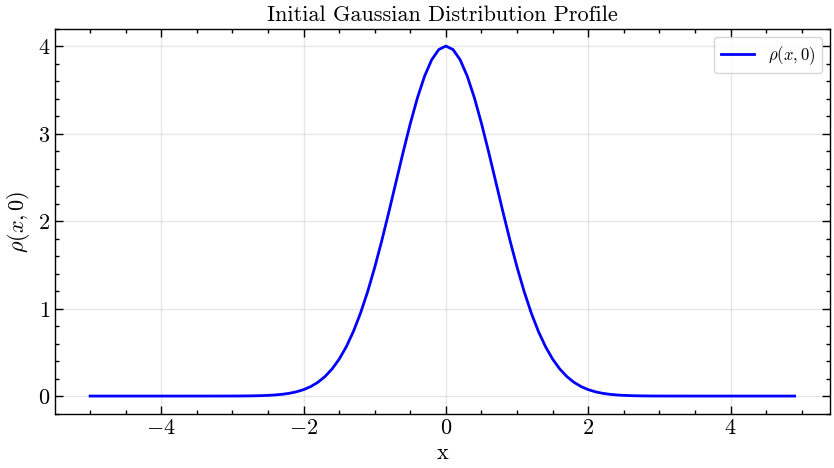

In [3]:
# Instantiate the ShockWaves class
shock_waves = ShockWavesInitialProfile(dx=0.1, Lx=10.0, dt=0.01, time_tot=10.0)

# Plot the initial profile
shock_waves.plot_initial_profile()

**(b)** Write a method for the right-hand-side (RHS) of the PDE that allows you to map in and out of the Fourier domain at each time. Note that this PDE is non-linear, so the function should return the RHS in real space. **Hint:** it may be helpful to write the derivative terms in our PDE in Fourier domain.

$$
\frac{\partial \rho}{\partial t}+\rho \frac{\partial \rho}{\partial x}=\alpha \frac{\partial^2 \rho}{\partial x^2} 
$$

From this equation we ontain the RHS of the PDE:

$$
\frac{\partial \rho}{\partial t}=\alpha \frac{\partial^2 \rho}{\partial x^2}-\rho \frac{\partial \rho}{\partial x} = RHS
$$

Then, the derivaties are expressed in Fourier $\mathcal{F} $ space: 

$$

\frac{\partial \rho}{\partial t}  \longrightarrow \hat{\rho}_t,

\\

\frac{\partial \rho}{\partial x} \rightarrow i k \hat{\rho}(k, t), 

\\

\frac{\partial^2 \rho}{\partial x^2} \longrightarrow-k^2 \hat{\rho}(k, t) 
$$

Remplazing this in our equation we get:

$$
\Rightarrow \quad \hat{\rho}_t(k, t)=-\alpha k^2 \hat{\rho}(k, t) - \rho(x, t) \cdot i k \hat{\rho}(k, t)
$$

This scheme will help to solve the rhs equation for integrating the PDE.

In [4]:
class ShockWavesSolverV1(ShockWavesInitialProfile):
    """
    """
    def __init__(self, dx=0.1, Lx=10.0, dt=0.01, time_tot=5.0, alpha=0.5):
        """
        Initialize the ShockWavesSolver class with parameters for simulation.
            Inputs:
                dx (float): Spatial step size.
                Lx (float): Length of the domain.
                dt (float): Time step size.
                time_tot (float): Total simulation time.
                alpha (float): Diffusion coefficient.
        """
        super().__init__(dx, Lx, dt, time_tot)

        self.alpha = alpha

        # Wavenumber
        self.k = 2 * np.pi * np.fft.fftfreq(len(self.x), d=self.dx)

    def rhs(self, rho):
        """
        Right hand size of the PDE for the shock wave solver.
            Inputs:
                rho (array): Density profile at the current time step.
            Output:
                rhs (array): Right-hand side of the PDE.
        """
        # Compute the Fast Fourier Transform of the density profile
        rho_hat = np.fft.fft(rho)

        # Compute the derivative in Fourier space and 
        rho_hat_dx = 1j * self.k * rho_hat

        # Transform back to real space
        rho_dx = np.fft.ifft(rho_hat_dx)

        # Compute the diffusion term in Fourier space
        rho_hat_dx2 = -self.k**2 * rho_hat

        # Compute the diffusion term in real space
        rho_dx2 = np.fft.ifft(rho_hat_dx2)

        # Compute the right-hand side of the PDE
        rhs = self.alpha * rho_dx2 - rho * rho_dx

        return rhs
    

**(c)** Choose a reasonable value for the diffusion constant, $\alpha$, and call your function in (b). What is this function achieving so far and what space (real or Fourier) is the output in?

In [5]:
# Define the difusion constant
alpha = 0.1 

# Instantiate the ShockWavesSolver class
shock_waves_solver = ShockWavesSolverV1(dx=0.01, Lx=10.0, dt=0.01, time_tot=10.0, alpha=alpha)

# Call the rhs method to compute the right-hand side of the PDE
rhs = shock_waves_solver.rhs(shock_waves_solver.rho_0)

In [6]:
print(f"The mean imaginary part is: {np.mean(np.abs(rhs.imag))}")

The mean imaginary part is: 1.0158746510908675e-12


In [7]:
# plt.figure(figsize=(10, 5))

# plt.plot(shock_waves_solver.x, rhs, label=r"$\rho(x, 0)$", color="blue")
# plt.title("Initial Gaussian Distribution Profile")

# plt.xlabel("x")
# plt.ylabel(r"$\rho(x, 0)$")

# plt.grid(alpha=0.3)
# plt.legend(frameon=True, fontsize=12)

# plt.show()

By using the function created in (b) it is seen that the results are in real space. The imaginary part of the output function is zero.

**(d)** Find and plot the solution, $\rho(x,t)$, **using your FFT method**. For this, you need to feed a scipy ODE integrator with the function you created in (b). **Hint:** make sure you feed the correct wavenumbers to the ODE integrator.

In [8]:
# Add the solution method to the class

class ShockWavesSolver(ShockWavesInitialProfile):
    """
    """
    def __init__(self, dx=0.1, Lx=10.0, dt=0.01, time_tot=5.0, alpha=0.5):
        """
        Initialize the ShockWavesSolver class with parameters for simulation.
            Inputs:
                dx (float): Spatial step size.
                Lx (float): Length of the domain.
                dt (float): Time step size.
                time_tot (float): Total simulation time.
                alpha (float): Diffusion coefficient.
        """
        super().__init__(dx, Lx, dt, time_tot)

        self.alpha = alpha

        # Wavenumber
        self.k = 2 * np.pi * np.fft.fftfreq(len(self.x), d=self.dx)

    def rhs(self, t, rho):
        """
        Right hand size of the PDE for the shock wave solver.
            Inputs:
                rho (array): Density profile at the current time step.
            Output:
                rhs (array): Right-hand side of the PDE.
        """
        # Compute the Fast Fourier Transform of the density profile
        rho_hat = np.fft.fft(rho)

        # Compute the derivative in Fourier space and 
        rho_hat_dx = 1j * self.k * rho_hat

        # Transform back to real space
        rho_dx = np.fft.ifft(rho_hat_dx)

        # Compute the diffusion term in Fourier space
        rho_hat_dx2 = - self.k**2 * rho_hat

        # Compute the diffusion term in real space
        rho_dx2 = np.fft.ifft(rho_hat_dx2)

        # Compute the right-hand side of the PDE
        rhs = self.alpha * rho_dx2 - rho * rho_dx

        return rhs.real # Return only the real part
    
    def solve(self):
        """
        Solver for the shock wave PDE using the scipy library.
            Output:
                sol (array): The solution object containing the time evolution of the density profile.
        """

        # Solve the PDE using scipy
        sol = solve_ivp(fun = self.rhs, t_span = (0., self.t[-1]), 
                        y0 = self.rho_0, method = 'RK45', t_eval = self.t, tol = 1.e-8, rtol = 1.e-8)
        
        # Pritn the message of success
        print(sol.message)

        # Extract the solution
        self.sol = sol.y

        return sol

In [9]:
# Define the difusion constant
alpha = 1.5

# Instantiate the ShockWavesSolver class
shock_waves_solver = ShockWavesSolver(dx = 0.01, Lx = 10.0, dt = 0.01, time_tot = 2.0, alpha = alpha)

# Solve the PDE
solution = shock_waves_solver.solve()

/home/alanp/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `tol`.
  warn("The following arguments have no effect for a chosen solver: {}."


The solver successfully reached the end of the integration interval.


In [10]:
class Plotter():
    """
    Class to plot the solution of the PDE.

    """ 
    def __init__(self, object):
        """
        Initialize the Plotter class with parameters for plotting.
            Inputs:
                x (array): Spatial points.
                t (array): Time points.
                solution (array): Solution of the PDE.
        """
        self.x = object.x
        self.t = object.t
        self.sol = object.sol
        self.alpha = object.alpha

        # Create a meshgrid for 2D plotting
        self.X, self.T = np.meshgrid(self.x, self.t)

    def plot_snapshots(self, frames = 10):
        """
        Plot snapshots of probability density at specified times.
            Input:  
                frames(int): Number of frames to plot selected within the time evolution.
            Output:
                A plot showing the evolution of the wavefunction over time.
        """
        
        # Create time indices
        t_step = self.t.shape[0] // frames
        time_indices = [(t_step*i) for i in range(0, frames - 1)]
        time_indices.append(- 1)  # Ensure the last index is included
        

        # Figure environment
        plt.figure(figsize = (10, 6))

        
        # Plot snapshots
        colors = plt.cm.inferno(np.linspace(0, 1, len(time_indices)))
        for i, t_idx in enumerate(time_indices):

            plt.plot(self.x, self.sol[:, t_idx], color=colors[i], label=f"t={self.t[t_idx]:.3f}")
        
        plt.xlabel("Position (x)")
        plt.ylabel(r"$\rho(x,t)$")
        plt.title(r"Time Evolution of a Shock Wave Profile ($\alpha =$ " + f"{self.alpha})")

        plt.legend(frameon = True, fontsize = 11)
        plt.grid(True, alpha = 0.3)
        plt.show()

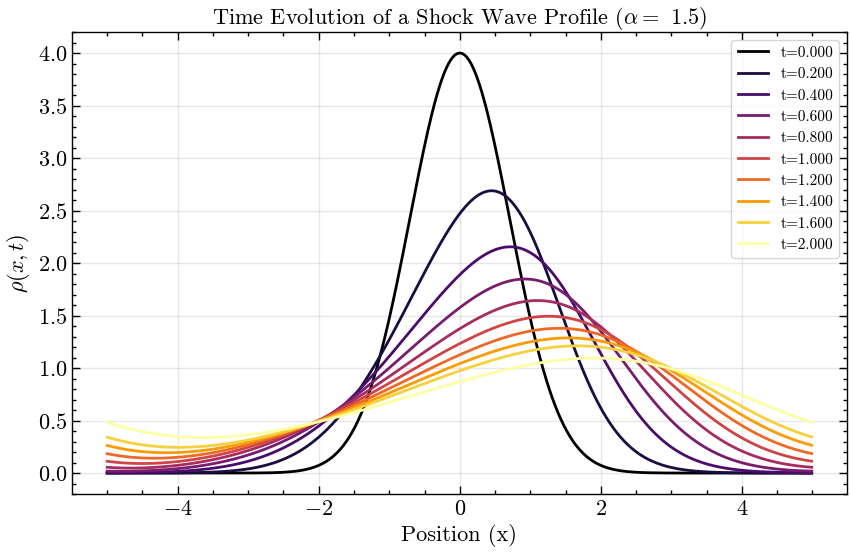

In [11]:
plotter = Plotter(shock_waves_solver)
plotter.plot_snapshots(frames=10)

**(e)** Repeat the above calculations for two additional $\alpha$ values (one of them should be 0). Then, make a figure (or movie) with three panels comparing the results for different $\alpha$ values and briefly discuss the role of this parameter in regulating the morphology of the shock wave.

In [12]:
# Define the difusion constant
alpha_2 = 0.5

# Instantiate the ShockWavesSolver class
shock_waves_solver_2 = ShockWavesSolver(dx = 0.01, Lx = 10.0, dt = 0.01, time_tot = 2.0, alpha = alpha_2)

# Solve the PDE
solution_2 = shock_waves_solver_2.solve()

The solver successfully reached the end of the integration interval.


In [13]:
# plotter2 = Plotter(shock_waves_solver_2)
# plotter2.plot_snapshots(frames=10)

In [14]:
# Define the difusion constant
alpha_3 = 1.e-1

# Instantiate the ShockWavesSolver class
shock_waves_solver_3 = ShockWavesSolver(dx = 0.1, Lx = 10.0, dt = 0.01, time_tot = 5.0, alpha = alpha_3)

# Solve the PDE
solution_3 = shock_waves_solver_3.solve()

The solver successfully reached the end of the integration interval.


In [15]:
# plotter3 = Plotter(shock_waves_solver_3)
# plotter3.plot_snapshots(frames=10)

**Animate the 3-panel figures**

In [16]:
class Animation():
    """
    Class to create an animation of the shock wave evolution with different diffusion coefficients.
    """
    def __init__(self, solutions):
        """
        Initialize the Animation class with parameters for animation.
            Input: 
                Solutions (list): List of solution objects for different diffusion coefficients
        """

        self.solutions = solutions
        self.x = solutions[0].x
        self.t = solutions[0].t

        # Define the colors for plotting each snapshot
        self.colors = plt.cm.inferno(np.linspace(0, 1, len(self.t)))

        # Define the name of the output file
        self.file_name = "shock_wave"

    def plot_shock_waves(self, j):
        """
        Function to save a figure of the shock wave solutions.
            Input: 
                j (int): Index of the time step to plot.
            Output:
                A plot showing the shock wave evolution at time step j for 
                each diffusion coefficient in the solutions list.
        """

        # Create a figure with subplots
        fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

        for i in range(len(axs)):

            axs[i].plot(self.solutions[i].x, self.solutions[i].sol[:, j], color=self.colors[j], label=f"t={self.solutions[i].t[j]:.3f}")

            axs[i].set_title(r"$\alpha =$" + f"{self.solutions[i].alpha}")
            axs[i].set_xlabel("Position (x)")
            #axs[i].set_ylabel(r"$\rho(x,t)$")

            axs[i].grid(True, alpha=0.3)
            axs[i].legend(frameon=True, fontsize=11)
            axs[i].set_xlim(-5, 5)
            axs[i].set_ylim(0, 5)

        # Set common labels
        axs[0].set_ylabel(r"$\rho(x,t)$")
        fig.suptitle("Shock Wave Evolution with Different Diffusion Coefficients", fontsize=17)    

        plt.tight_layout()

        # Save the figure frame
        plt.savefig(self.output_dir + f"/{self.file_name}" + ".{:03d}.png".format(j))   
        plt.close() 
        
    def animate(self):
        """
        Generate an animated GIF from the evolution of the wavefunction.
            Outputs:
                GIF saved in the output folder.
        """
        # Create a directory to save the figures
        if os.path.isdir("outputfolder_P2"):
            print(f"Directory 'outputfolder' already exists.")
        else:
            print(f"Directory 'outputfolder_P2' has been created.")
            os.mkdir("outputfolder_P2")

        # Define the directory name for saving the figures
        name_dir = "outputfolder_P2" 
       
        # Create all images
        n_cpu = mp.cpu_count() // 2
        print(f"The image generation is distributed among {n_cpu} cores")
        self.output_dir = name_dir # Define output folder

        # Paralelize image generation
        pool = mp.Pool(processes = n_cpu)
        pool.map(self.plot_shock_waves, range(0, self.t.shape[0]))

        #Read all the generated figures to create the movie

        #Define the input directory
        images_input = name_dir + f"/{self.file_name}.***.png"

        # Collect the images
        imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))

        img = next(imgs)

        #Define the output directory
        imgif_output = name_dir + f"/{self.file_name}.gif"

        # Save the GIF
        img.save(fp = imgif_output, format="GIF", append_images=imgs,\
                save_all=True, duration = 100, loop = 0)
                    
        return print(f"The movie was generated correctly in '{name_dir}/' as:", f"{self.file_name}.gif")

In [17]:
# Define the list of solutions to be animated
solutions = [shock_waves_solver, shock_waves_solver_2, shock_waves_solver_3]

# Instantiate the Animation class
animation = Animation(solutions)

# Generate the animation
animation.animate()

Directory 'outputfolder_P2' has been created.
The image generation is distributed among 4 cores
The movie was generated correctly in 'outputfolder_P2/' as: shock_wave.gif


In [18]:
# Show the animation (uncomment this)
from IPython.display import Image, display

# display(Image(filename="outputfolder_P2/shock_wave.gif"))

As expected, the diffusivity factor affects the contribution of the parabolic term included to avoid a discontinuity or shock wave. When the diffusivity factor $\alpha$ is higher, the evolution of the density profile is smoother and maintains a finite width. However, when $\alpha$ is close to zero, a discontinuity starts to form over time, making the shock wave evident. The smaller the value of $\alpha$, the steeper the shock becomes.